In [2]:
# import sys
# import gymnasium as gym
# sys.modules["gym"] = gym
import gym
gym.__version__

'0.21.0'

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [4]:
import os
import numpy as np
import torch
print(torch.cuda.is_available())

True


In [5]:
import gnwrapper

In [6]:
env_id = "CarRacing-v0"
NUM_CPU = 4  # Number0of processes to use

# Observ Wrapper
```
import gym
from scipy.spatial import distance
import numpy as np

class CarRacingGroundTruthObsWrapper(gym.ObservationWrapper):
    def __init__(self, env, num_obs_points: int = 6):
        super().__init__(env)
        self.num_obs_points = num_obs_points
        self.low_state = np.array(
            [0, -np.pi, *[-float('inf'), -float('inf'), -np.pi]*self.num_obs_points], dtype=np.float32
        )
        self.high_state = np.array(
            [100, np.pi, *[float('inf'), float('inf'), np.pi]*self.num_obs_points], dtype=np.float32
        )
        self.observation_space = gym.spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )
        
    def observation(self, obs):
        velocity = np.sqrt(
            np.square(self.car.hull.linearVelocity[0])
            + np.square(self.car.hull.linearVelocity[1])
        )
        angular_velocity = self.car.hull.angularVelocity
        # ABS sensors
        # abs_sensors = []
        # for i in range(4):
            # abs_sensors.append(0.01 * self.car.wheels[i].omega)
        car_position =  np.array(self.car.hull.position)
        car_angle = -self.car.hull.angle

        track = np.array(self.track)
        track_size = track.shape[0]

        rot = np.array([[np.cos(car_angle), -np.sin(car_angle)], [np.sin(car_angle), np.cos(car_angle)]])
        arg = np.argmin(distance.cdist([car_position], track[:, 2:4]))
        path = rot @ (track[np.r_[arg+1-track_size:arg+1+self.num_obs_points-track_size], 2:4] - car_position).T
        path_angles = np.expand_dims(np.arctan2(*path), axis=0)
        
        return np.array([velocity, angular_velocity, *np.concatenate((path, path_angles), axis=0).ravel(order='F')])
```

In [7]:
# env = DummyVecEnv([lambda: CarRacingGroundTruthObsWrapper(gym.make(env_id))])
from utils import CarRacingGroundTruthObsWrapper
def wrapper(env):
    env = CarRacingGroundTruthObsWrapper(env) 
    env = gnwrapper.Animation(env)
    return env

# Training 'expert' and 'noob' policy
Skip this if you have trained policies

In this notebool used DummyVecEnv, it doesn't support Multi Processing. If you have a power PC, I recomend use PPO_CarRacing.py for training

In [ ]:
env = make_vec_env(env_id, n_envs=NUM_CPU, wrapper_class=wrapper)
env.observation_space

In [ ]:
from utils import linear_schedule

model = PPO("MlpPolicy",
            env,
            verbose=1,
            seed=0,
            batch_size=512,
            learning_rate=linear_schedule(1e-03),
            n_epochs=10,
            n_steps=8*NUM_CPU,
           )
model.learn(total_timesteps=100_000, progress_bar=True)
model = PPO.save("ppo_CarRacing_expert")

env.close()

In [ ]:
# env = make_vec_env(env_id, n_envs=NUM_CPU, wrapper_class=gnwrapper.Animation)
# env.observation_space.shape

In [ ]:
# OrderedDict([('batch_size', 128),
#              ('clip_range', 0.2),
#              ('ent_coef', 0.0),
#              ('env_wrapper',
#               [{'rl_zoo3.wrappers.FrameSkip': {'skip': 2}},
#                {'gym.wrappers.resize_observation.ResizeObservation': {'shape': 64}},
#                {'gym.wrappers.gray_scale_observation.GrayScaleObservation': {'keep_dim': True}}]),
#              ('frame_stack', 2),
#              ('gae_lambda', 0.95),
#              ('gamma', 0.99),
#              ('learning_rate', 'lin_1e-4'),
#              ('max_grad_norm', 0.5),
#              ('n_envs', 8),
#              ('n_epochs', 10),
#              ('n_steps', 512),
#              ('n_timesteps', 4000000.0),
#              ('normalize', "{'norm_obs': False, 'norm_reward': True}"),
#              ('policy', 'CnnPolicy'),
#              ('policy_kwargs',
#               'dict(log_std_init=-2, ortho_init=False, activation_fn=nn.GELU, '
#               'net_arch=dict(pi=[256], vf=[256]), )'),
#              ('sde_sample_freq', 4),
#              ('use_sde', True),
#              ('vf_coef', 0.5),
#              ('normalize_kwargs', {'norm_obs': False, 'norm_reward': False})])


In [ ]:
# from utils import linear_schedule

# # Hyperparameters from https://huggingface.co/sb3/ppo-CarRacing-v0
# model = PPO("CnnPolicy",
#             env,
#             verbose=1,
#             seed=0,
#             batch_size=128,
#             learning_rate=linear_schedule(1e-04),
#             n_epochs=10,
#             n_steps=8*NUM_CPU,
#            )
# model.learn(total_timesteps=100_000, progress_bar=True)
# model = PPO.load("ppo_CarRacing_expert", print_system_info=True)

# env.close()

# Visual testing of policies

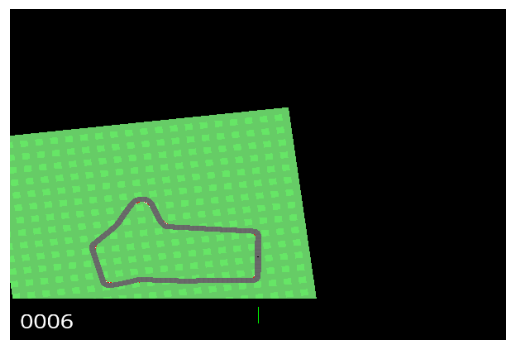

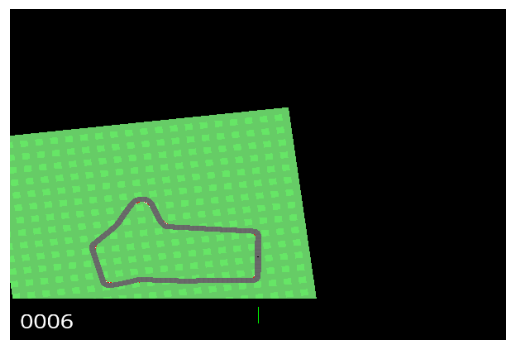

In [11]:
env = make_vec_env(env_id,
                        wrapper_class=wrapper,
                        n_envs=1)

# expert = PPO.load("./logs/ppo_MountainCar_expert.zip", print_system_info=True)
expert = PPO.load("./policy/ppo_CarRacing_expert-1kk.zip", print_system_info=True)

obs = env.reset()
while True:
    action, _states = expert.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    # print(obs)
    if dones:
        break
    
env.close()

In [ ]:
env = DummyVecEnv([lambda: CarRacingGroundTruthObsWrapper(gym.make(env_id))])
# env = gnwrapper.Animation(env)

# env = DummyVecEnv([lambda: env])
obs = env.reset()
for _ in range(10000):
    action, _states = model.predict(obs)
    # action = np.array([0.1, 0.01, 0])
    obs, rewards, dones, info = env.step(action)
    env.render()